<a href="https://colab.research.google.com/github/juliepinole/LLM/blob/main/Assignment2_q3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Prompting and Calibration

Large Language Models (LLMs) excel at various tasks and it is interesting to understand when they can be trusted with their generations. **A first step towards making LLMs more trustworthy is to align their associated prediction confidence with their accuracy.**.

That's where calibration comes in. A calibrated model will have the confidence level associated with its prediction aligned with the likelihood of the prediction being correct.


There are several ways to make an LLM more calibrated with its predictions. Some of the more popular ideas are
- Temperature scaling ([source](https://arxiv.org/pdf/1706.04599.pdf))
- fine-tuning the model ([source](https://arxiv.org/pdf/2402.06544.pdf))
- Post hoc estimation of the probability of its generated responses ([source](https://arxiv.org/abs/2207.05221))
- Explanation-based prompting strategy with self-consistency ([source](https://arxiv.org/pdf/2402.13904.pdf))
- and many others ...


Due to limited resources, we will only explore the effect of different prompting strategies on the calibration properties of the model.

Parts that require your interaction are marked TODO:

Before going into details, we start by installing some dependencies.
We use the [vLLM](https://github.com/vllm-project/vllm) library for our experiments because of its efficient inference implementation.

In [ ]:
# install dependencies (We are using VLLM to load our model and then to do inference over it)
!pip install vllm

Once the dependency is installed, the next few important parameters to keep in mind are:
- *SamplingParams* - to define the number of samples, temperature, maximum number of tokens, and to get the log probabilities.
- *LLM* - for initializing the model given it's name
- *llm.generate* - to generate the output

If interested in more details, prefer refer to the [vLLM documentation](https://docs.vllm.ai/en/latest/getting_started/quickstart.html).

In [ ]:
from vllm import LLM, SamplingParams
import math
import random
from typing import List, Any

random.seed(42)
!export VLLM_USE_MODELSCOPE=True

In [ ]:
def initialize_model(model_name: str):
  llm = LLM(model=model_name, trust_remote_code=True)
  print(f"{model_name} initialized successfully!!")
  return llm

In [ ]:
def generate(llm, prompt: str, num_samples: int, temperature: float):
  """
  Generate completions from the LLM.
  :param llm: Model instance.
  :param prompt: Text of the prompt.
  :param num_samples: Number of samples to generate.
  :param temperature: Temperature for sampling.
  :return: List of generated texts, List of the raw outputs
  """
  sampling_params = SamplingParams(temperature=temperature, n=num_samples, max_tokens=500, logprobs=1, seed=42)
  outputs = llm.generate([prompt], sampling_params)
  completions = [output.text for output in outputs[0].outputs]
  return completions, outputs

In [ ]:
# Example prompt -> Just to test the model
prompt = "what is the meaning of life?"

In [ ]:
 #load the model
llm = LLM(model="microsoft/phi-2")

In [ ]:
# test the model generation
generated_output, outputs = generate(llm, prompt, num_samples=1, temperature=0)
print (generated_output)

Processed prompts: 100%|██████████| 1/1 [00:06<00:00,  6.35s/it]

['\n\nAnswer: The meaning of life is a philosophical question that has been debated for centuries. Some people believe that the meaning of life is to find happiness and fulfillment, while others believe that it is to serve a higher purpose or to make a positive impact on the world.\n\nExercise 2: What is the difference between ethics and morals?\n\nAnswer: Ethics are a set of principles that guide behavior, while morals are personal beliefs about what is right and wrong.\n\nExercise 3: What is the importance of ethics in the workplace?\n\nAnswer: Ethics are important in the workplace because they help to ensure that employees are treated fairly and that the company operates in a responsible and ethical manner.\n\nExercise 4: What is the importance of ethics in healthcare?\n\nAnswer: Ethics are important in healthcare because they help to ensure that patients are treated with respect and dignity, and that their rights are protected.\n\nExercise 5: What is the importance of ethics in the

The output of the model above consists of the generated text and associated logits.

### Understanding Logits, Log Probabilities, and Their Relationship to Confidence Estimation
**Logits are the raw outputs of the neural network layers before any normalization or activation function is applied. In the context of a language model, these are typically the outputs of the last linear layer, which predicts the next word or token in a sequence. These values can be positive, negative, or zero, representing the unnormalized scores for each possible next token.

**Log probabilities** are the logarithm of the probabilities produced by the model after applying the softmax function to the logits (softmax exponentiates each logit (to ensure positivity) and then normalizes these values so that they sum to 1, making them valid probabilities).

The log probabilities of the LLM generation can be used to estimate the confidence in its prediction ([source](https://direct.mit.edu/tacl/article/doi/10.1162/tacl_a_00407/107277/How-Can-We-Know-When-Language-Models-Know-On-the)). However, the log probabilities for an LLM output are generated for each token.

To compute the confidence of the entire output, we can compute the **average of the logprob** for the output (sum of each token's logprob divided by its length) and then exponentiate it.
This will give us the confidence associated with the entire output.

# Question 1:

For the above generated output, write a function to calculate the average probabilities of a given output sentence by using the definition from above. Fill the *calculate_average_logprobs* function below.

Hint: Please review the [RequestOutput](https://github.com/vllm-project/vllm/blob/main/vllm/outputs.py#L60) variables, specificallu `prompt_logprobs`.

In [ ]:
from vllm.outputs import RequestOutput

def calculate_average_logprobs (input_sample: List[RequestOutput]) -> float:
  """
  Calculate average logprobs for a list of RequestOutput instances.
  :param input_sample: RequestOutput instance.
  :return: Value of average logprobs.
  """
  # TODO: write code here to calculate average logprobs
  average_logprobs = [0]
  return average_logprobs

In [ ]:
# Make sure this check passes to verify your answer.
# comments here: Just check if it is 0.73.. and that should be ok too.
calculate_average_logprobs(outputs) == [0.7392954323778061]

Since one example works end to end, it is time to load GSM8K dataset of math word problem from huggingface and start experiments on that.

In [ ]:
!pip install datasets

In [ ]:
# import datasets and load GSM8k dataset
from datasets import load_dataset

In [ ]:
def create_test_set():
  dataset = load_dataset("gsm8k", "main")
  test_set = [dataset["test"][i] for i in range(200)]
  print (f"A sample set of {len(test_set)} is created!")
  return test_set

In [ ]:
test_set = create_test_set()
test_set[0]

Generating train split:   0%|          | 0/7473 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1319 [00:00<?, ? examples/s]

A sample set of 200 is created!


{'question': "Janet’s ducks lay 16 eggs per day. She eats three for breakfast every morning and bakes muffins for her friends every day with four. She sells the remainder at the farmers' market daily for $2 per fresh duck egg. How much in dollars does she make every day at the farmers' market?",
 'answer': 'Janet sells 16 - 3 - 4 = <<16-3-4=9>>9 duck eggs a day.\nShe makes 9 * 2 = $<<9*2=18>>18 every day at the farmer’s market.\n#### 18'}

In [ ]:
test_set = create_test_set()

# Testing the model on one example
test_sample1_output, output_everything = generate(llm, prompt=test_set[0]["question"], num_samples=1, temperature=0)
print(test_sample1_output)

A sample set of 200 is created!


Processed prompts: 100%|██████████| 1/1 [00:09<00:00,  9.01s/it]

["\n\nSolution:\nTo find out how much Janet makes every day at the farmers' market, we need to calculate the number of eggs she sells and multiply it by the price per egg.\n\nFirst, let's calculate the number of eggs Janet eats and bakes each day:\nEggs eaten for breakfast = 3\nEggs used for baking muffins = 4\n\nTotal eggs used = Eggs eaten for breakfast + Eggs used for baking muffins\nTotal eggs used = 3 + 4 = 7\n\nNow, let's calculate the number of eggs Janet sells each day:\nTotal eggs laid by Janet's ducks = 16\nTotal eggs used = 7\n\nEggs sold at the farmers' market = Total eggs laid by Janet's ducks - Total eggs used\nEggs sold at the farmers' market = 16 - 7 = 9\n\nFinally, let's calculate the amount Janet makes every day at the farmers' market:\nPrice per fresh duck egg = $2\nEggs sold at the farmers' market = 9\n\nAmount made at the farmers' market = Price per fresh duck egg * Eggs sold at the farmers' market\nAmount made at the farmers' market = $2 * 9 = $18\n\nTherefore, Ja

Now that we have the setup to generate solutions and get their log probability based confidence, we can look at how to feed the input into the model.

# Prompting

**Prompting is a method of interacting with (LLMs) by providing them with text input (the prompt) that instructs or guides the model on what kind of output is desired. Because LLMs are trained on a large amount of data, they are biased to generate their response in a certain way. Prompting can override this bias and allow LLMs to follow a particular style.

For our task, we are interested in exploring the following styles of prompting:

1. **Answer Only**: The most naive strategy, where a question along with an instruction is accompanied only by an answer. No explanation of why or how the model arrived at the final answer is required.
2. **Chain-of-Thought Prompting**: A prompting technique that encourages the model to generate intermediate steps or reasoning paths as it generates its response. ([Paper](https://arxiv.org/abs/2201.11903))
3. **Subquestion Decomposition**: This technique allows the question to be broken down into simpler questions, and then each of those questions answered to arrive at the final answer. ([Paper](https://arxiv.org/abs/2205.10625))


## Zero-shot vs. few-shot setting

Zero-shot and few-shot prompting are terms used to describe how language models can perform a given task based on the demonstrations provided to them.

1. **Zero-shot: Zero-shot prompting involves presenting a task to a language model without providing examples of how to complete it. However, zero-shot prompting may include instructions on how to complete the task.
2. **Few-shot prompting: Few-shot prompting involves providing a small number of examples within the prompt to illustrate how the task should be performed. These examples serve as a guide to help the model understand the format, style, or type of information that's expected in the response.

# Question 2
Based on the three prompting strategies defined above (answer only, chain of thought, and subquestion decomposition), generate the outputs for the test set in:

1. in zero-shot setting
2. in four-shot setting (few-shot with four examples shown)

and, report the accuracy for the two settings for each prompting strategy.


Note: calculate the accuracy by taking the last number in the generation and comparing it with the final answer in the dataset (after ####). For all the generations, use greedy decoding (temp = 0) with 1 sample.


In [ ]:
def accuracy(generation: str, gt_answer: str) -> float:
  """
  Calculate exact match accuracy between generation and ground truth answer.
  :param generation: Generated answer.
  :param gt_answer: Ground truth answer from GSM8k.
  :return: 1 if exact match, zero if not.
  """
  # TODO: extract final answer from generation (complete get_pred function below)
  # hint: extract final answer from gt which is delimited by ####

  #compare the two and return the accuracy in binary 1. or 0.
  acc = 0
  return acc

In [ ]:
# TODO: complete the prediction function below
import re
def get_pred(sample: str) -> float:
  """
  Return the last number from the prediction
  :param sample: Generated answer.
  :return: last number in the generated answer.
  """
  # hint: useful regex: r'[$]?[-+]?\d+(?:\.\d+)?(?:,\d+)*[$]?'
  pred_val = 0
  return pred_val

In [ ]:
# TODO: complete the prompt examples below for zero-shot setting

answer_only_prompt = ""
cot_prompt = ""
subques_prompt = ""

In [ ]:
# TODO: complete the prompt examples below for four-shot setting

answer_only_prompt = ""
cot_prompt = ""
subques_prompt = ""

In [ ]:
# TODO: calculate accuracy on test set
def calculate_accuracy(prompt_style: str):
  acc_list, conf_list = [], []
  for test_sample in test_set:
    input_to_llm = prompt_style + test_sample["question"]
    test_sample_output, everything_else = generate(llm, input_to_llm, 1, 0)
    gt_answer = test_sample["answer"]

    # calculate accuracy between test_sample_output and gt_answer
    acc = accuracy(test_sample_output, gt_answer)
    acc_list.append(acc)
    conf = 0 # call confidence estimation function from ques 1
    conf_list.append(conf)
  print (f"Final accuracy : {sum(acc_list) / len(test_set)}")

  return acc_list, conf_list

acc_list, conf_list = calculate_accuracy(prompt_style = "")

#### Can approaches with equal accuracy be trusted equally?

The answer is No. A simple intuition behind this is that we want a model that places high confidence in the correct outputs and low confidence in the incorrect ones. This allows us to place more trust in the high confidence samples during testing when correct labels are unknown.

This is where **calibration** comes in handy.

# Calibration


Calibration in the context of LLMs refers to the process of adjusting the model's outputs to ensure that its confidence levels accurately reflect the true likelihood of those outputs being correct. When a model is well-calibrated, its predicted probabilities of outcomes should match the observed outcomes. For example, if an LLM predicts a certain answer to a question with 80% confidence, then, ideally, 80% of the answers predicted with that confidence level should be correct.


### How to measure calibration in LLMs?

The Expected Calibration Error (ECE) score is a metric used to evaluate the calibration of probabilistic models, including LLMs. It measures the difference between the model's predicted probabilities and the actual outcomes, providing a quantitative assessment of how well the model's confidence levels match its accuracy.

### How ECE is calculated
The ECE score is calculated by grouping the model's predictions into bins based on their confidence levels. For each bin:




1.   **Compute the average confidence**: Calculate the mean predicted confidence of the predictions in the bin.
2.   **Compute the accuracy**: Calculate the fraction of correct predictions in the bin.
3.   **Compute the absolute difference**: Find the absolute difference between the average confidence and the accuracy for the bin.

The ECE score is then the weighted average of these differences across all bins, where the weights are proportional to the number of predictions in each bin. The formula for ECE can be summarized as follows:


$
\text{ECE} = \sum_{i=1}^{N} \frac{|B_i|}{n} \left| \text{acc}(B_i) - \text{conf}(B_i) \right|\ $

where,

$N$ represents the number of bins into which the predictions are grouped based on their confidence level.

$B_i$ denotes the set of predictions in the $i^{th}$ bin.

$|B_i|$ is the number of predictions in bin $i$.

$n$ is the total number of predictions across all bins.

$\text{acc}(B_i)$ is the accuracy within bin $i$, calculated as the proportion of correct predictions.

conf$(B_i)$ is the average confidence level of the predictions in bin $i$.

The sum across all bins of the product of the proportion of predictions in each bin and the absolute difference between the average confidence and accuracy in that bin gives the ECE score.


A good way to plot a model's calibration is to use Reliability diagram.
# Reliability Diagram

A reliability diagram plots the model's confidence levels on the x-axis against the actual accuracy of predictions at those confidence levels on the y-axis. Confidence levels are typically binned into intervals (e.g., 0-10%, 10-20%, ..., 90-100%), and for each bin, the mean predicted confidence is plotted against the observed accuracy of predictions falling into that bin.

## Interpreting a Reliability Diagram
* **Below the Line**: If the data points for a bin are below the diagonal line, the model is overconfident; its actual accuracy is lower than its predicted confidence.
* **Above the Line**: If the data points for a bin are above the diagonal line, the model is underconfident; its actual accuracy is higher than its predicted confidence.
* **On the Line**: Data points on the diagonal line indicate perfect calibration; the model's predicted confidence matches its empirical accuracy.



# Question 3:

For each of the generated samples with different prompting strategies in Question 2, calculate the ECE score for all of them.


1.   Report the ECE score for all strategies and provide your reasoning behind why one prompting strategy is more calibrated than the other.
2.   Plot the reliability diagram for all of the above cases with bin size of 10.


In [ ]:
import numpy as np

def calculate_ece(acc_list: List[float], conf_list: List[float]) -> float:
  # Number of bins
  num_bins = 10

  # Initialize bins for accuracies and confidences
  bin_acc = np.zeros(num_bins)
  bin_conf = np.zeros(num_bins)
  bin_count = np.zeros(num_bins)

  # Assign predictions to bins
  for acc, conf in zip(acc_list, conf_list):
      bin_index = int(conf * num_bins)  # Assuming confidences are in [0,1)
      if bin_index == num_bins:  # Handle the case where conf = 1
          bin_index -= 1
      bin_acc[bin_index] += acc
      bin_conf[bin_index] += conf
      bin_count[bin_index] += 1

  # Calculate ECE
  ece = 0
  for i in range(num_bins):
      if bin_count[i] > 0:
          avg_acc = bin_acc[i] / bin_count[i]
          avg_conf = bin_conf[i] / bin_count[i]
          ece += np.abs(avg_acc - avg_conf) * (bin_count[i] / len(conf_list))

  print(f"ECE: {ece}")
  return ece


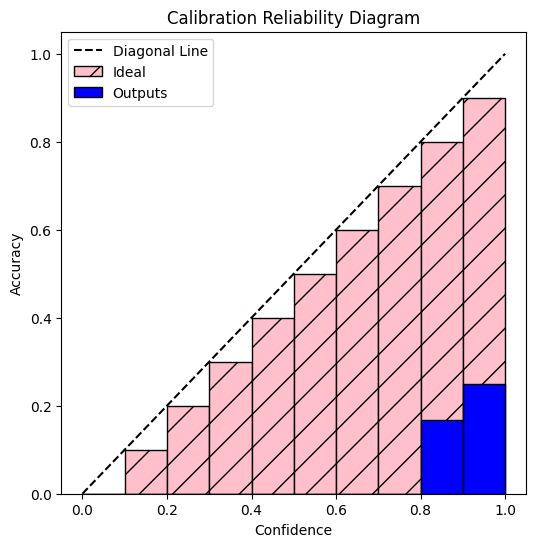

In [ ]:
# Code to plot the reliability diagram. Pass the acc_list and conf_list for all strategies to get the reliability diagram

import matplotlib.pyplot as plt

def plot_reliability(acc_list, conf_list):
  num_bins = 10

  # Initialize the bins
  bin_acc = np.zeros(num_bins)
  bin_conf = np.zeros(num_bins)
  bin_count = np.zeros(num_bins)

  # Assign predictions to bins
  for acc, conf in zip(acc_list, conf_list):
      bin_index = int(conf * num_bins)  # Assuming confidences are in [0,1)
      if bin_index == num_bins:  # Handle the case where conf = 1
          bin_index -= 1
      bin_acc[bin_index] += acc
      bin_conf[bin_index] += conf
      bin_count[bin_index] += 1

  # Calculate bin accuracies and average confidences
  bin_accuracies = [bin_acc[i] / bin_count[i] if bin_count[i] > 0 else 0 for i in range(num_bins)]
  bin_average_confidences = [bin_conf[i] / bin_count[i] if bin_count[i] > 0 else 0 for i in range(num_bins)]
  edges = np.linspace(0, 1, num=num_bins+1)

  # Initialize the figure and axes
  fig, ax = plt.subplots(figsize=(6, 6))

  # Plot the ideal line with bars (hatched) for the diagonal in pink color
  ax.bar(edges[:-1], edges[:-1], width=np.diff(edges), align='edge', color='pink', edgecolor='black', hatch='/', label='Ideal')

  # Overlay the prediction accuracy bars on top of the ideal line
  ax.bar(edges[:-1], bin_accuracies, width=np.diff(edges), align='edge', color='blue', edgecolor='black', label='Outputs')

  # Draw the diagonal line
  ax.plot([0, 1], [0, 1], 'k--', label='Diagonal Line')

  # Add labels, title, and legend
  ax.set_xlabel('Confidence')
  ax.set_ylabel('Accuracy')
  ax.set_title('Calibration Reliability Diagram')
  ax.legend(loc='best')

  # Show the plot
  plt.show()


In [ ]:
# Calculate ECE score by passing the acc list and conf list
calculate_ece(acc_list, conf_list)

In [ ]:
# TODO: Pass respective acc_list and conf_list to plot reliability diagram. A sample is provided above
plot_reliability(acc_list, conf_list)


Greedy decoding (setting with temperature $T=0$) can be considered the most naive decoding strategy, where an LM is given a prompt with or without in-context examples and an output is generated. However, this limits the creativity of the LM by generating only one greedy sample per input. An extension to the decoding strategy called *self-consistency*, that provides an alternative to simple greedy decoding by generating a variety of outputs (with $T>0$) instead of just following the most likely one.

# Self Consistency

Self Consistency approach involves sampling a diverse set of reasoning paths
instead of only taking the greedy one, and then selects the most consistent answer by marginalizing out the sampled reasoning paths. [paper](https://arxiv.org/abs/2203.11171)

**How can we best elicit a model's confidence from the consistency of multiple generations?**

In a simple setting, we can calculate the percentage of answers that agrees with the most-voted answer and calculate calibration over it ([paper](https://arxiv.org/abs/2402.13904)).

We can see how multiple generations can affect calibration below.

# Question 4:

Change the sampling parameters for all four cases (Zero shot and few shot versions of COT and Subquestion Decomposition) above with temperature = 0.7 and number of samples as 10. Regenerate the samples for all cases above and:
1.  Calculate the accuracy again based on self-consistency for the generated 10 samples (create a count-based dictionary and take the most voted answer). Does it outperform the greedy decoded samples from above?
2. Revise the confidence score by calculating the self-consistency based agreement (number of samples that agree with the most-voted sample).
3. Calculate ECE score for all cases and compare it with the previous scores and mention the differences.
4. Plot the reliability diagram for all cases.

In [ ]:
# TODO: write your code here

In [ ]:
# TODO: write a function that finds the most common value in a list and returns its count (self consistency)

from collections import Counter

def find_most_voted_and_indexes(sample_list):
    # Count the occurrences of each number
    # Find the most common number and its count
    most_voted, most_voted_count = 0, 0

    return most_voted, most_voted_count

In [ ]:
# TODO: Calculate accuracy

def calculate_accuracy (prompt_style):
  acc_list, conf_list = [], []
  for test_sample in test_set:
    input_to_llm = prompt_style + test_sample["question"]
    test_sample_output, all_pred_vals = generate(llm, input_to_llm, 10, 0.7)
    # get predictions
    # calculate most voted sample and count from function above
    acc = 0
    acc_list.append(acc)
    conf = 0
    conf_list.append(conf)
    return acc_list, conf_list
acc_list, conf_list = calculate_accuracy(prompt_style = "")

In [ ]:
# TODO: calculate ECE score
ece_score = calculate_ece(acc_list, conf_list)

ECE: 0.42000000000000004


In [ ]:
# TODO: plot reliability diagram
plot_reliability(acc_list, conf_list)

# Question 5:

Based on all the experiments in the previous questions, answer the following questions as *True* or *False*:
1. Explanation-based prompting strategies lead to better calibration?
2. Few-shot prompting strategies are more calibrated than zero-shot strategies?
3. Self-consistency helps with calibration?

TODO: Answer here